In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
mnist = input_data.read_data_sets('mnist/',one_hot = True)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [4]:
image = mnist.train.images[1].reshape([28,28])
label = mnist.train.labels[1]

In [9]:
mnist.train.labels

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

3
Tensor("ArgMax_1:0", shape=(), dtype=int64)


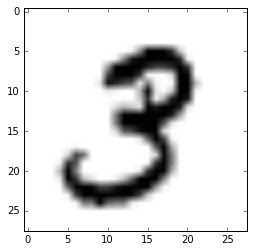

In [53]:
plt.rcParams['image.cmap'] = 'Greys'
plt.imshow(image)
print ([a for a,b in enumerate(label) if b == max(label)][0])
print (tf.argmax(label,1))

In [150]:
inputs = tf.placeholder(tf.float32, [None,784])
labels = tf.placeholder(tf.float32,[None,10])

In [151]:
#nonlinear multilayer
w_h = tf.Variable(tf.truncated_normal([784,400],stddev=0.1))
b_h = tf.Variable(tf.constant(0.1,shape=[400]))
hidden_1 = tf.nn.relu(tf.add(tf.matmul(inputs,w_h),b_h))
w_2 = tf.Variable(tf.truncated_normal([400,100],stddev = 0.1))
b_2 = tf.Variable(tf.constant(0.1,shape=[100]))
hidden_2 = tf.nn.relu(tf.matmul(hidden_1,w_2)+b_2)
w_o = tf.Variable(tf.truncated_normal([100,10],stddev=0.1))
b_o = tf.Variable(tf.constant(0.1,shape = [10]))
logit = tf.add(tf.matmul(hidden_2,w_o),b_o)
out = tf.nn.softmax(tf.add(tf.matmul(hidden_2,w_o),b_o))
#bad idea, acc = 0.1 with hidden layer, acc = 0.9 without hidden layer

#linear
w = tf.Variable(tf.truncated_normal([784,10]))
b = tf.Variable(tf.zeros(10))
out = tf.nn.softmax(tf.matmul(inputs,w)+b)
logit = tf.matmul(inputs,w)+b

In [152]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logit,labels=labels))
#loss = tf.reduce_mean(-tf.reduce_sum(labels*tf.log(out), reduction_indices=[1]))

In [153]:
train = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

In [154]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [155]:
for i in range(2000):
    batch_xs,batch_ys = mnist.train.next_batch(100)
    sess.run(train,feed_dict={inputs:batch_xs,labels:batch_ys})

In [156]:
correct_prediction = tf.equal(tf.argmax(out,1),tf.argmax(labels,1))

In [157]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [158]:
sess.run(accuracy,feed_dict = {inputs:mnist.test.images,labels:mnist.test.labels})

0.97780001

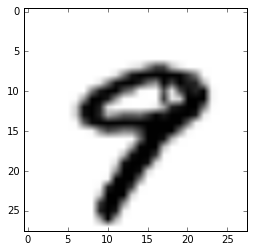

In [159]:
plt.imshow(mnist.test.images[9].reshape([28,28]))

In [160]:
print (sess.run(out,feed_dict={inputs:[mnist.test.images[9]]}))

[[  1.10607322e-10   1.48248047e-09   4.67171679e-09   5.91709579e-08
    5.49336430e-03   9.22371015e-08   3.04618067e-11   3.42084313e-05
    9.80449272e-07   9.94471312e-01]]


CONV_NET

In [ ]:
#conv net
def get_input(images):
    return images.reshape([-1,28,28,1])
def get_labels(labels):
    return labels.reshape([-1,10])
inputs = get_input(mnist.train.images)

In [238]:
def cov_net(input_tensor,cov_k_size,cov_stride,n_cov_output,pool_size,pool_stride):
    
    w = tf.Variable(tf.truncated_normal([cov_k_size,cov_k_size,input_tensor.get_shape().as_list()[3],n_cov_output],mean = 0,stddev = 5e-2))
    b = tf.Variable(tf.zeros([n_cov_output]))
    cov = tf.nn.conv2d(input_tensor,w,[1,cov_stride,cov_stride,1],padding = 'SAME')
    cov_bias = tf.nn.bias_add(cov,b)
    cov_pool = tf.nn.max_pool(cov_bias,[1,pool_size,pool_size,1],[1,pool_stride,pool_stride,1],'SAME')
    return cov_pool                   

In [239]:
def flatten(input_tensor):
    return tf.contrib.layers.flatten(input_tensor)

In [245]:
def fully_connected(input_tensor,n_output):
    w = tf.Variable(tf.truncated_normal([input_tensor.get_shape().as_list()[1],n_output]))
    b = tf.Variable(tf.zeros([n_output]))
    output = tf.nn.relu(tf.add(tf.matmul(input_tensor,w),b))
    return output

In [250]:
def output(input_tensor):
    w = tf.Variable(tf.truncated_normal([input_tensor.get_shape().as_list()[1],10]))
    b = tf.Variable(tf.zeros([10]))
    return tf.add(tf.matmul(input_tensor,w),b)

In [251]:
x = tf.placeholder(tf.float32, [None,28,28,1])
y = tf.placeholder(tf.float32,[None,10])

In [255]:
def conv_net(x,keep_prob):
    a = cov_net(x,5,1,32,4,2)
    a = tf.nn.dropout(a,keep_prob)
    a = cov_net(a,5,1,16,4,2)
    a = tf.nn.dropout(a,keep_prob)
    a = flatten(a)
    a = fully_connected(a,500)
    a = fully_connected(a,200)
    a = output(a)
    return a

In [256]:
logits = conv_net(x,0.5)

In [259]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits,labels = y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

In [258]:
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

In [264]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
for i in range(20000):
    batch_x,batch_y = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(session = sess,feed_dict = {x:get_input(batch_x),y:get_labels(batch_y)})
        print ('Step %d, training_accuracy %g'%(i,train_accuracy))
    optimizer.run(session = sess,feed_dict ={x:get_input(batch_x),y:get_labels(batch_y)} )

Step 0, training_accuracy 0.12
Step 100, training_accuracy 0.26
Step 200, training_accuracy 0.38
Step 300, training_accuracy 0.36
Step 400, training_accuracy 0.52
Step 500, training_accuracy 0.48
Step 600, training_accuracy 0.6
Step 700, training_accuracy 0.74
Step 800, training_accuracy 0.78
Step 900, training_accuracy 0.72
Step 1000, training_accuracy 0.66
Step 1100, training_accuracy 0.7
Step 1200, training_accuracy 0.72
Step 1300, training_accuracy 0.78
Step 1400, training_accuracy 0.88
Step 1500, training_accuracy 0.78
Step 1600, training_accuracy 0.84
Step 1700, training_accuracy 0.82
Step 1800, training_accuracy 0.82
Step 1900, training_accuracy 0.9


In [265]:
sess.run(accuracy,feed_dict = {x:get_input(mnist.test.images),y:get_labels(mnist.test.labels)})

0.8556